### Import libraries

In [1]:
# Data analysis essential
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None # to turn off the chained assignments

# Explorotory data analysis and visualisation essential
import matplotlib.pyplot as plt
import seaborn as sns

### Data Preparation

#### Reading files with Pandas

In [2]:
# Load inventories data into Pandas
df_inventories = pd.concat(
    map(pd.read_csv, ['data/lego_sets_2012.csv', 'data/lego_sets_2013.csv', 'data/lego_sets_2014.csv', 'data/lego_sets_2015.csv', 'data/lego_sets_2016.csv', 'data/lego_sets_2017.csv', 'data/lego_sets_2018.csv', 'data/lego_sets_2019.csv', 'data/lego_sets_2020.csv', 'data/lego_sets_2021.csv', 'data/lego_sets_2022.csv']), ignore_index= True)

In [3]:
df_inventories.head()

,Number,Theme,Subtheme,Year,Set name,Minifigs,Pieces,RRP (GBP),RRP (USD),RRP (CAD),...,Flag 3 not used,Flag 4 not used,Flag 5 not used,Flag 6 not used,Flag 7 not used,Flag 8 not used,Value new (USD),Value used (USD),Launch date,Exit date
0,3061-1,Friends,NaN,2012,City Park Cafe,2.0,222.0,29.99,34.99,39.99,...,NaN,NaN,NaN,NaN,NaN,NaN,32.44,16.33,01/01/2012,31/12/2013
1,3063-1,Friends,NaN,2012,Heartlake Flying Club,1.0,195.0,19.99,19.99,24.99,...,NaN,NaN,NaN,NaN,NaN,NaN,28.55,6.72,01/06/2012,31/12/2013
2,3065-1,Friends,NaN,2012,Olivia's Tree House,1.0,191.0,19.99,19.99,24.99,...,NaN,NaN,NaN,NaN,NaN,NaN,50.00,11.19,01/01/2012,31/12/2013
3,3183-1,Friends,NaN,2012,Stephanie's Cool Convertible,1.0,130.0,14.99,14.99,17.99,...,NaN,NaN,NaN,NaN,NaN,NaN,16.84,7.93,01/01/2012,31/07/2013
4,3184-1,Friends,NaN,2012,Adventure Camper,2.0,309.0,29.99,34.99,39.99,...,NaN,NaN,NaN,NaN,NaN,NaN,60.00,19.06,01/06/2012,31/12/2013


In [4]:
# Load scraped data on Ebay into pandas
df_ebay = pd.read_csv('lego_ebay_sold_price.csv')

In [5]:
df_ebay.describe()

,title,currency,sold_price,sold_date
count,57601,57216,57216,57827
unique,28918,2,7479,23
top,title,£,sold_price,18 Sep 2022
freq,947,56269,947,5565


### Clean inventories data

In [6]:
# Remove unused columns and copy to new DataFrame
df_inventories_cleaned = df_inventories[['Number', 'Theme', 'Pieces', 'RRP (GBP)', 'Launch date', 'Exit date']]

In [7]:
# Check any missing data
df_inventories_cleaned.isnull().sum()

Number            0
Theme             0
Pieces         2337
RRP (GBP)      3442
Launch date    4326
Exit date      4326
dtype: int64

Any missing RRP will be not useful in this analysis. We have about 3442 of them.

In [8]:
# Handling missing data: simply drop them
df_inventories_cleaned = df_inventories_cleaned[~df_inventories_cleaned['RRP (GBP)'].isna()]

In [9]:
# Remove the unused "hyphen-digit" part in Numbers and convert into the Int type
df_inventories_cleaned['Number'] = df_inventories_cleaned['Number'].str.replace(r'-\d+', '', regex=True).str.replace(r'\D','', regex=True)
df_inventories_cleaned = df_inventories_cleaned[~(df_inventories_cleaned['Number'] == '')]
df_inventories_cleaned['Number'] = df_inventories_cleaned['Number'].astype('int64')

In [10]:
# Format the date
df_inventories_cleaned[['Launch date', 'Exit date']] = df_inventories_cleaned[['Launch date', 'Exit date']].apply(pd.to_datetime,  format='%d/%m/%Y')

In [11]:
# Check the cleaned dataframe
df_inventories_cleaned.head()

,Number,Theme,Pieces,RRP (GBP),Launch date,Exit date
0,3061,Friends,222.0,29.99,2012-01-01,2013-12-31
1,3063,Friends,195.0,19.99,2012-06-01,2013-12-31
2,3065,Friends,191.0,19.99,2012-01-01,2013-12-31
3,3183,Friends,130.0,14.99,2012-01-01,2013-07-31
4,3184,Friends,309.0,29.99,2012-06-01,2013-12-31


### Clean scraped Ebay data

In [12]:
# Extract all numbers in title to a list in a new DataFrame: this might contain LEGO's set code, number of pieces, set quantity, number of minifigures, etc.
df_numbers = df_ebay['title'].str.findall('([0-9]+)').to_list()

# Express all values in list to multi columns, each with one value.
# As with LEGO sets, the number of pieces is usually smaller than the actual number code. Other number are significantly smaller than the pieces and number code.
# Fill all nan value with 0, convert to int data type to find the max value

# df_numbers = df_ebay.numbers.apply(pd.Series).fillna(0).astype(int).max(axis=1)
df_numbers = pd.DataFrame([pd.Series(x, dtype = 'float') for x in df_numbers]).fillna(0).astype(int).max(axis=1) # Use this method to avoid the warning: 'The default dtype for empty Series will be 'object' instead of 'float64' in a future version warning'

In [13]:
# Load all nessesary columns to dataframe
df_ebay_cleaned = df_ebay[['title','sold_price', 'sold_date']]
df_ebay_cleaned.loc[:,'Number'] = df_numbers

In [14]:
# Remove duplicates rows
df_ebay_cleaned = df_ebay_cleaned.drop_duplicates()

In [15]:
# Are those any invalid values: set number smaller than 999 and larger than 99999. LEGO set number are from 3-digit-number to 5-digit-number.
filter = ((df_ebay_cleaned['Number'] < 999) | (df_ebay_cleaned['Number'] > 99999))
filter.sum()

6317

In [16]:
# There are invalid values. We're going to drop them.
# Take only row with a valid numbers: number set is from 999 to 99999. 
df_ebay_cleaned = df_ebay_cleaned[~filter]

In [17]:
# Check if any null values in the df
df_ebay_cleaned.isnull().sum()

# We droped any row with sold_price is null
df_ebay_cleaned = df_ebay_cleaned[df_ebay_cleaned['sold_price'].notnull()]

# And convert sold price to float
df_ebay_cleaned['sold_price'] =df_ebay_cleaned['sold_price'].astype(float)

In [18]:
# Format the date
df_ebay_cleaned['sold_date'] = df_ebay_cleaned['sold_date'].apply(pd.to_datetime,  infer_datetime_format=True)

In [19]:
df_ebay_cleaned.head()

,title,sold_price,sold_date,Number
0,Lego STAR WARS MILLENNIUM FALCON BRAND NEW 135...,108.79,2022-09-09,75257
1,LEGO 40499 Santa's Sleigh (343 pcs) Brand New!...,67.73,2022-09-09,40499
2,LEGO 76208 Marvel Thor Love & Thunder. The Goa...,37.49,2022-09-09,76208
3,LEGO City 60161 - Jungle Exploration Site - BR...,145.00,2022-09-09,60161
4,Lego 75299 Trouble on Tatooine new factory sea...,22.00,2022-09-09,75299


### Combine two dataset

In [20]:
df = pd.merge(df_ebay_cleaned, df_inventories_cleaned, how='inner', on =['Number'])

In [21]:
df.describe()

,sold_price,Number,Pieces,RRP (GBP)
count,31079.000000,31079.000000,29614.000000,31079.000000
mean,54.093866,57707.190354,547.784730,46.449209
std,84.398304,22359.134127,920.528455,72.606986
min,0.850000,3061.000000,0.000000,0.000000
25%,11.630000,41239.000000,88.000000,8.990000
50%,27.710000,71022.000000,262.000000,20.990000
75%,57.915000,75270.000000,610.000000,54.990000
max,1128.300000,92177.000000,11695.000000,734.990000


### Cartogrise set size

LEGO have different number of pieces per set. It might just contains as little as 13 pcs to nearly 10,000 pcs in just one set. For this analysis, there are three cartogries used for sizing LEGO set:
* Small < 500 pcs
* Medium = 500-1000 pcs
* Large > 1000 pcs

In [22]:
# Put each set into three groups in column 'Size'
df['Pieces'] = df['Pieces'].fillna(0).astype('int64')
df.loc[df['Pieces'] <= 500, 'Size'] = 'Small Set'
df.loc[(df['Pieces'] > 500) & (df['Pieces'] <= 1000) ,'Size'] = 'Medium Set'
df.loc[df['Pieces'] > 1000, 'Size'] = 'Large Set'

### Calculate Year to Retire

The availability of the LEGO set is one of the primary reasons for the formation of the secondary market. If the set is retired, it will be difficult to find on the official LEGO store/website. As a result, it is worthwhile to compute the year-to-retirement for each set to observe how it affects market performance.

In [23]:
# Calculate number of years until the set is retired. Result to column 'year_to_retire'
df['year_to_retire'] = round((df['Exit date'] - df['sold_date'])/np.timedelta64(1, 'Y'))

### Questions and Answer

### 1. Are sales equally distributed across all themes ? What are the sales for each theme?

In [24]:
# Number of different themes
len(df['Theme'].unique())

78

There are nearly 80 diffrent themes found in the scraped EBAY data. Let's find out which theme has the most sales.

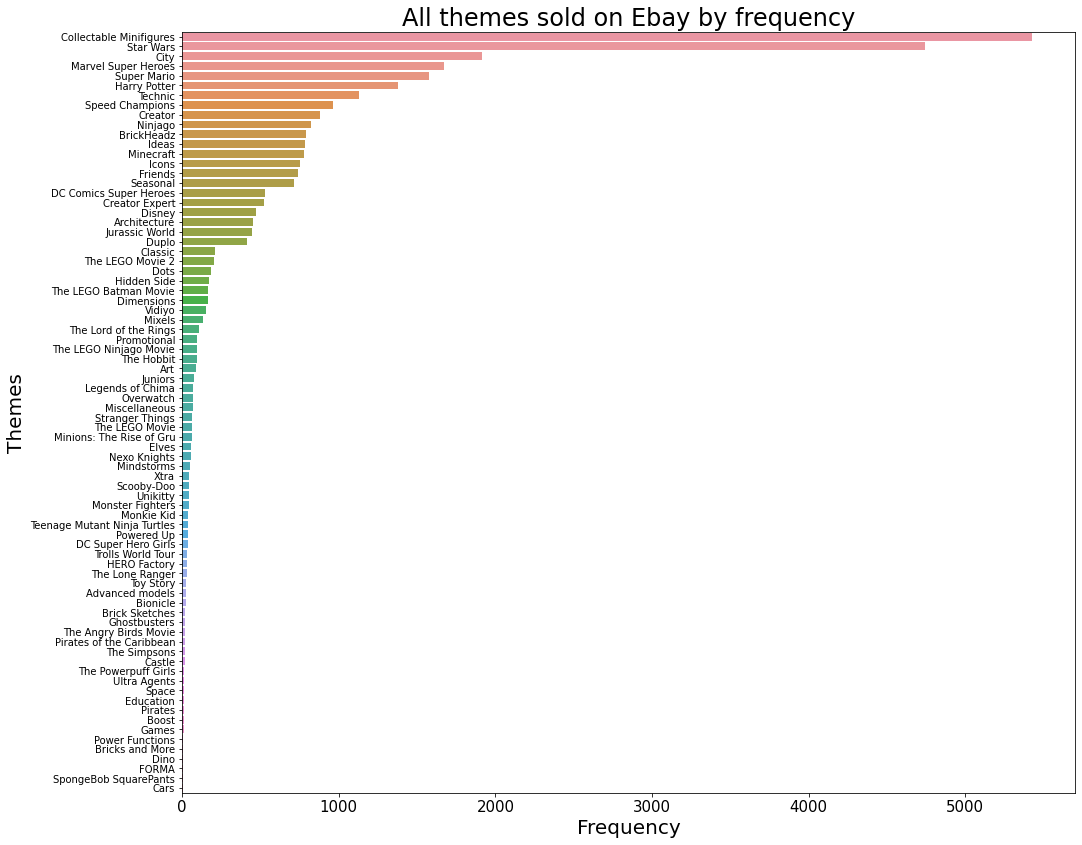

In [25]:
fig, ax = plt.subplots(figsize = (16,14))
themes_count = df['Theme'].value_counts()
ax = sns.barplot(x = themes_count, y = themes_count.index, data=df)
plt.xticks(size=15)
plt.xlabel('Frequency', size = 20)
plt.ylabel('Themes', size = 20)
plt.title('All themes sold on Ebay by frequency', size = 24)
plt.show()


Top themes can be named as 'Collectable Minifigures', 'Star Wars', 'City', 'Marvel Super Heroes','Super Mario' and 'Harry Potter'. All have more than 1000 sales
On the other hand, there are a number of themes have verry little sales (< 100). So these are considered as outlier and we will remove them in the analysis.

In [26]:
# Remove outlier themes.
ix = df['Theme'].value_counts()[df['Theme'].value_counts()<100].index
index = df[df['Theme'].isin(ix)].index
df.drop(index, axis=0, inplace=True)

In [27]:
len(df['Theme'].unique())

31

We will use about 30 themes in the analysis.

### 2. What are the diffence in sales in each size ?

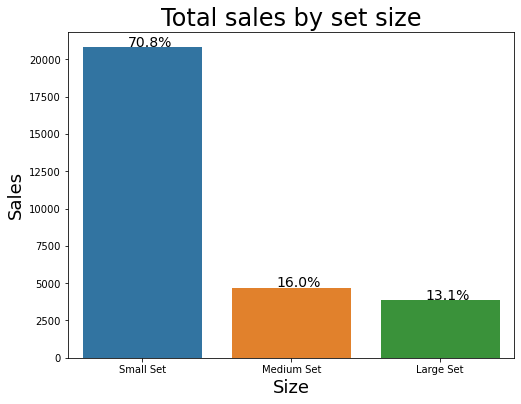

In [28]:
fig, ax = plt.subplots(figsize = (8,6))
ax = sns.countplot(x =df['Size'], order=df['Size'].value_counts().index)
# Calculate percentage and draw on top 
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/len(df['Size']))
    x = p.get_x() + p.get_width() / 2 - 0.1
    y = p.get_y() + p.get_height() + 75
    ax.annotate(percentage, (x, y), size = 14)
ax.set_xlabel('Size', size=18)
ax.set_ylabel('Sales', size=18)
ax.set_title('Total sales by set size', size = 24)
plt.show()

About 70% sold set has less than 500pcs

Let's also have a look at sales by theme and size

In [29]:
dfg = df.groupby(['Theme','Size']).agg(Frequency=('Size', 'size')).reset_index()

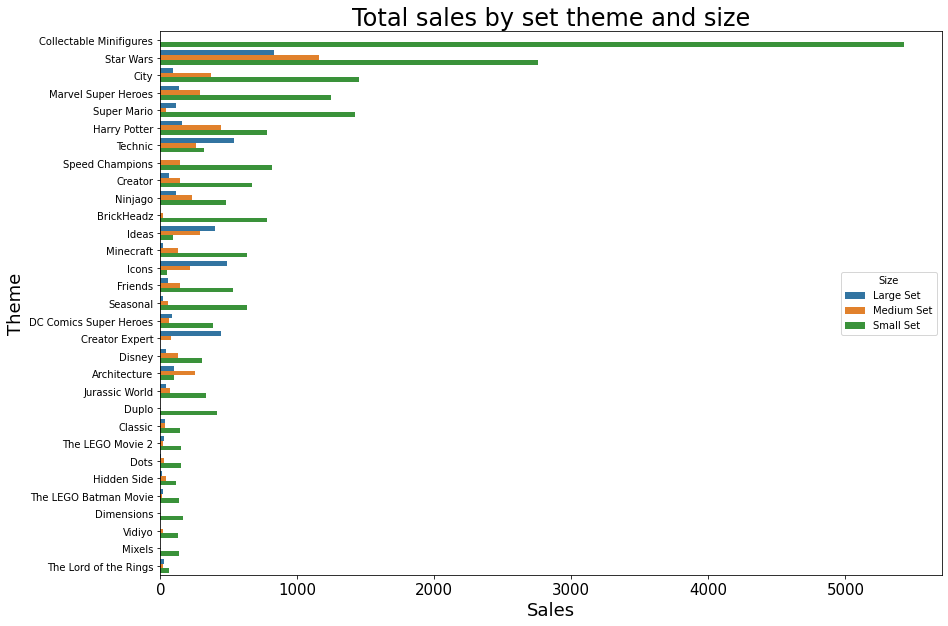

In [30]:
fig, ax = plt.subplots(figsize=(14,10))
colors = sns.color_palette('pastel')
# dfg= df.groupby(['Theme','Size']).size()
ax = sns.barplot(data=dfg, y='Theme', x='Frequency', hue='Size', order=df['Theme'].value_counts().index)
# ax = df.groupby(['Theme','Size']).size().unstack().plot(kind='barh', figsize=(14,10), stacked=True)

plt.xlabel('Sales', size = 18)
plt.xticks(size=15)
plt.ylabel('Theme', size = 18)
plt.title('Total sales by set theme and size', size = 24)

plt.show()

* Most of the sets sold on Ebay are small sets. 
* It is true for Collectable Minifigures, Star Wars, City and Marvel Super Heroes theme.
* For other most active themes like Super Mario, medium set sold more than small sets; Technic has most sales in large sets.

### 3. What are the sales for regarding to the set retire date ?

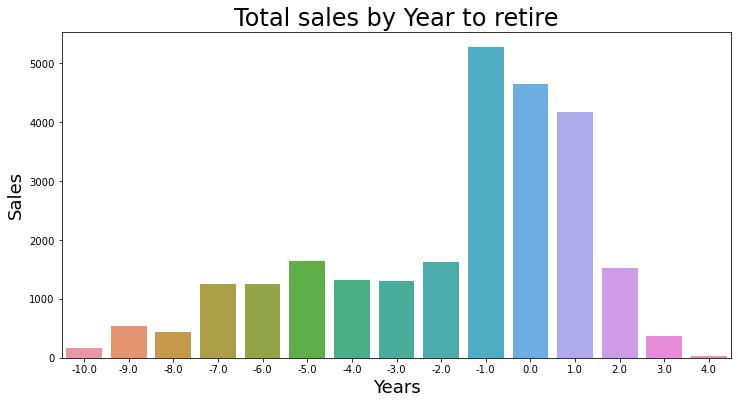

In [31]:
fig, ax = plt.subplots(figsize = (12,6))
sns.countplot(x =df['year_to_retire'])
ax.set_xlabel('Years', size=18)
ax.set_ylabel('Sales', size=18)
ax.set_title('Total sales by Year to retire', size = 24)
plt.show()

As demonstrated in the graph, sets retired one year ago to sets recently retired sold the most. Then there are the sets that are about to retire in a year. This corresponds to my expectations, given the secondary market is generally linked to set availability on the official LEGO store/website/official partner. Once the set has retired or is going to retire, it will be more valuable and active in the secondary market, such as Ebay.

### 4. What is the distribution of sold prices ?

Text(0.5, 1.0, 'Histogram of sold price')

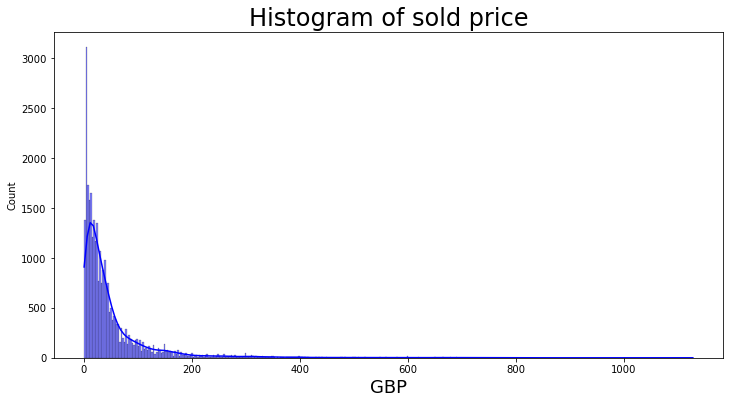

In [32]:
fig, ax = plt.subplots(figsize=(12,6))
ax = sns.histplot(data=df, x='sold_price', color='blue', label='Sold Price', kde=True)
plt.xlabel('GBP', size = 18)
plt.title('Histogram of sold price', size= 24)

The sold price is very skewed to the right, meaning that there might be outliers in the dataset.

### 5. The general rule of LEGO price is the more pieces, the more expensives. So what is the distribution of sold price size wise?

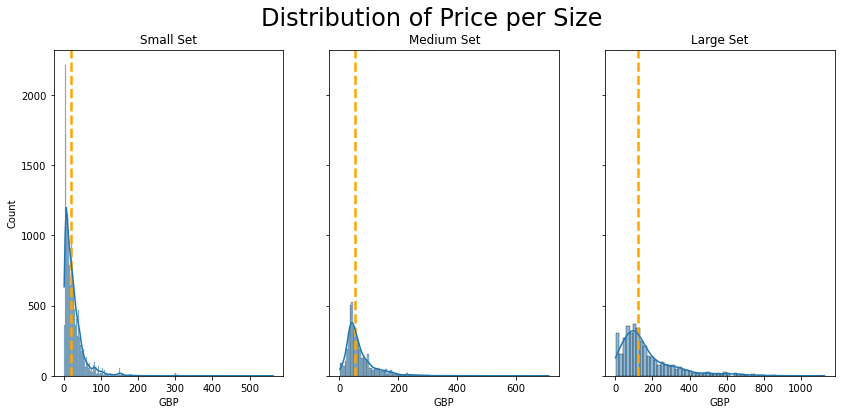

In [33]:
fig, axes = plt.subplots(1, 3, figsize = (14,6), sharey=True)

# iterate through each axes
for ax in axes:
    
    # select the data for the sizes
    if ax == axes[0]:
        data = df[df['Size'] == 'Small Set']['sold_price']
    if ax == axes[1]:
        data = df[df['Size'] == 'Medium Set']['sold_price']
    if ax == axes[2]:
        data = df[df['Size'] == 'Large Set']['sold_price']
    
    # plot the lines
    ax.axvline(x=data.median(), c='orange', ls='--', lw=2.5)


sns.histplot(data=df, x=df[df['Size'] == 'Small Set']['sold_price'], ax=axes[0], kde=True)
axes[0].set(title='Small Set', xlabel='GBP')
sns.histplot(data=df, x=df[df['Size'] == 'Medium Set']['sold_price'], ax=axes[1], kde=True)
axes[1].set(title='Medium Set', xlabel='GBP')
sns.histplot(data=df, x=df[df['Size'] == 'Large Set']['sold_price'], ax=axes[2], kde=True)
axes[2].set(title='Large Set', xlabel='GBP')
fig.suptitle('Distribution of Price per Size', size = 24)
plt.show()

### 6. What about the sold price theme wise ?

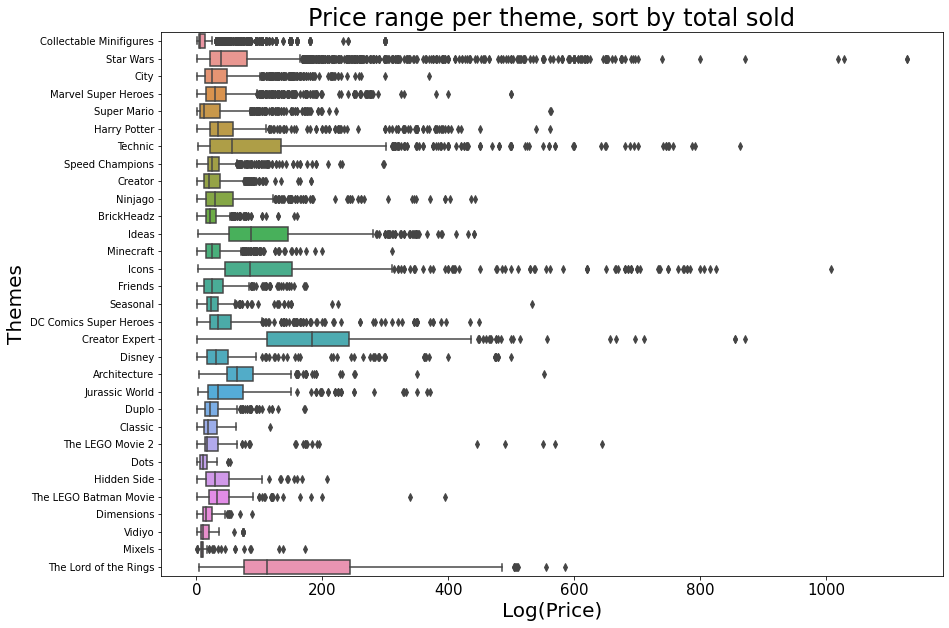

In [34]:
fig, ax = plt.subplots(figsize = (14,10))
order = df['Theme'].value_counts().index
ax = sns.boxplot(data=df, x='sold_price', y='Theme', order=order)
plt.xticks(size=15)
plt.xlabel('Log(Price)', size = 20)
plt.ylabel('Themes', size = 20)
plt.title('Price range per theme, sort by total sold', size = 24)
plt.show()

We can see that even after cartogrising the set by size, the price data are still skewed to the right. We are also interested in the percentage change in price.  One typical method is to apply log transformation to the metric. As a result, we use log on sold price and RRP in this scenario.

### Applying log to the price

In [35]:
df['log_sold_price'] = np.log10(df['sold_price'], where=df['sold_price']>0)
df['log_RRP'] = np.log10(df['RRP (GBP)'], where=df['RRP (GBP)']>0)

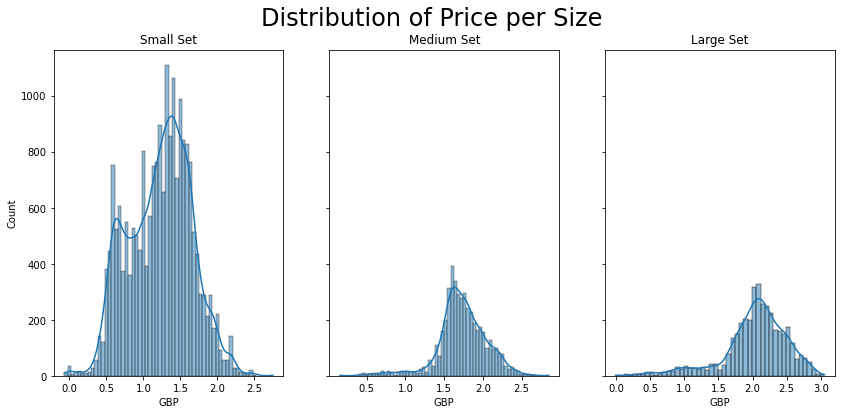

In [36]:
fig, axes = plt.subplots(1, 3, figsize = (14,6), sharey=True)

sns.histplot(data=df, x=df[df['Size'] == 'Small Set']['log_sold_price'], ax=axes[0], kde=True)
axes[0].set(title='Small Set', xlabel='GBP')
sns.histplot(data=df, x=df[df['Size'] == 'Medium Set']['log_sold_price'], ax=axes[1], kde=True)
axes[1].set(title='Medium Set', xlabel='GBP')
sns.histplot(data=df, x=df[df['Size'] == 'Large Set']['log_sold_price'], ax=axes[2], kde=True)
axes[2].set(title='Large Set', xlabel='GBP')
fig.suptitle('Distribution of Price per Size', size = 24)
plt.show()
# plt.xticks(size=15)
# plt.xlabel('Size', size = 18)
# plt.ylabel('Sold Price (GBP)', size = 18)

The log sold price now follows the normal distribution. We use this metric for the analysis

### 7. What is the relationship between Price vs Theme, Price vs Size, Price vs Year to Retire

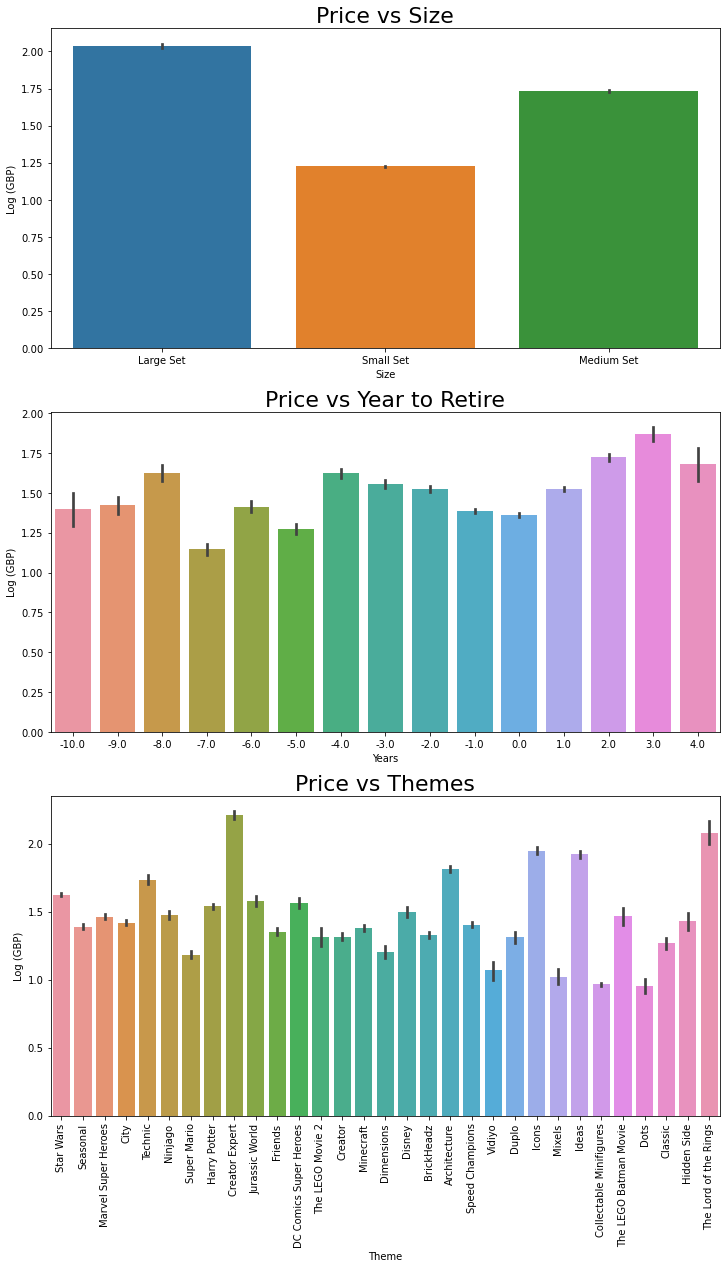

In [37]:
fig, axes = plt.subplots(3,1, figsize = (12,20))

sns.barplot(data=df, x='Size', y='log_sold_price', ax=axes[0])
axes[0].set_title('Price vs Size', size = 22)
axes[0].set(xlabel='Size', ylabel='Log (GBP)')
sns.barplot(data=df, x='year_to_retire', y='log_sold_price', ax=axes[1])
axes[1].set_title('Price vs Year to Retire', size = 22)
axes[1].set(xlabel='Years', ylabel='Log (GBP)')
sns.barplot(data=df, x='Theme', y='log_sold_price', ax=axes[2])
axes[2].set_title('Price vs Themes', size=22)
axes[2].set(xlabel='Theme', ylabel='Log (GBP)')
axes[2].tick_params('x', labelrotation=90)
plt.show()


* As expected, large sets has higher sold price, followed by medium sets and small sets.
* Year-to-Retire vs Sold Price metrics are quite flat, it is difficult to tell anything at this point.
* Themes like 'Creator Expert', 'Icons', 'Ideas' and 'Architecture' have higher sold price.

### 8. What we can say about the profit in the secondary market?

Profit is the most important factor in any market. This is, of course, our focus while researching the LEGO secondary market. So, using the dataset we have, we examine the profit of the LEGO secondary market in this section.

In [38]:
# The log profit is calculated
df['profit'] = df['log_sold_price'] - df['log_RRP']

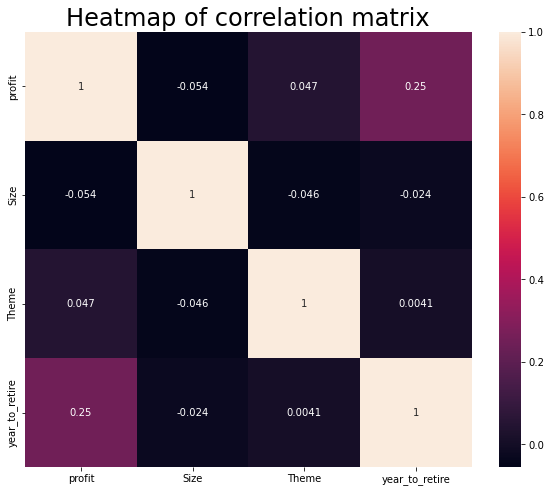

In [39]:
# To get an overview relationship between profit and other metrics (Size, Theme and Year to Retire), the correlation matrix between those is calculated.
corr_matrix = df.apply(lambda x: x.factorize()[0]).corr(method ='pearson').loc[['profit', 'Size', 'Theme', 'year_to_retire'],['profit', 'Size', 'Theme', 'year_to_retire']]
# Plot into a heatmap for visualisation
fig, ax = plt.subplots(figsize = (10,8))
ax = sns.heatmap(corr_matrix, annot=True)
ax.set_title('Heatmap of correlation matrix', size = 24)
plt.show()

The heatmap shows that Year-to-Retire has the greatest impact on profit. Though the other two have only a minor impact. There can be no conclusion without investigating further.

### 9. What is the relationship between Profit vs Size

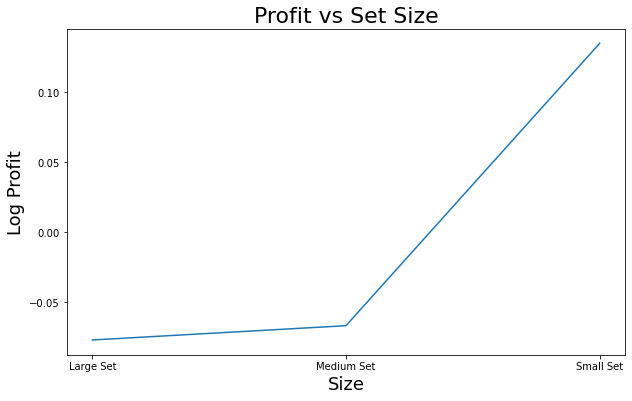

In [40]:
dfp = df.groupby(['Size'])['profit'].median().reset_index()
fig, ax = plt.subplots(figsize = (10,6))
ax = sns.lineplot(data=dfp, x='Size', y='profit')
plt.xlabel('Size', size = 18)
plt.ylabel('Log Profit', size = 18)
plt.title('Profit vs Set Size', size = 22)
plt.show()

Small sets have the highest profit margins, whereas large sets have the lowest. Furthermore, the large and medium sets are losing money. 
To comprehend this, keep in mind that the profit is measured against the RRP. In real life, LEGO sets go on SALE multiple times during their lifespan. 
According to studies, buyers can typically get a LEGO kit for 20% - 40% OFF when sales, promotions, or loyalty points are used. Let's have a look:

In [41]:
# Bought at 20% OFF
df['profit_off_20'] = df['log_sold_price'] - df['log_RRP'] * 0.8
# Bought at 40% OFF
df['profit_off_40'] = df['log_sold_price'] - df['log_RRP'] * 0.6

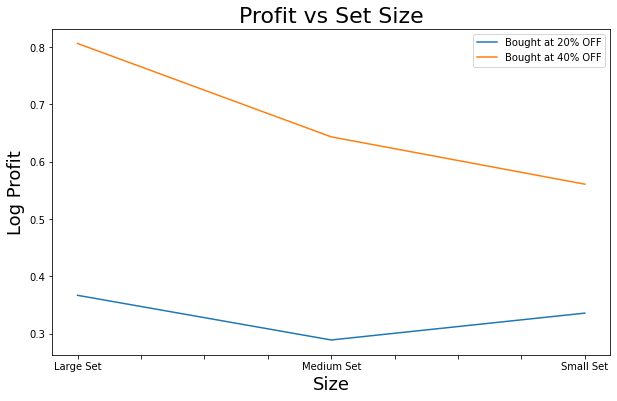

In [42]:
# Visualisation
fig = df.groupby(['Size'])['profit_off_20'].median().plot(figsize=(10,6), label='Bought at 20% OFF')
df.groupby(['Size'])['profit_off_40'].median().plot(label='Bought at 40% OFF')
plt.legend()
plt.xlabel('Size', size = 18)
plt.ylabel('Log Profit', size = 18)
plt.title('Profit vs Set Size', size = 22)
plt.show()

Surprisingly, when a set is purchased at a 20% discount, medium sets produce the least profit, while large sets come out on top with a slightly better profit margin than small sets. When a set is purchased at 40% off, the large set returns the largest profit, followed by the medium and small sets.

### 10. What is the relationship between Profit vs Theme

In [43]:
dft = df.groupby(['Theme'])[['profit','profit_off_20','profit_off_40']].median().reset_index()
dfl = dft.melt(id_vars='Theme', var_name='cats', value_name='values').sort_values('values', ascending=False).reset_index(drop=True)

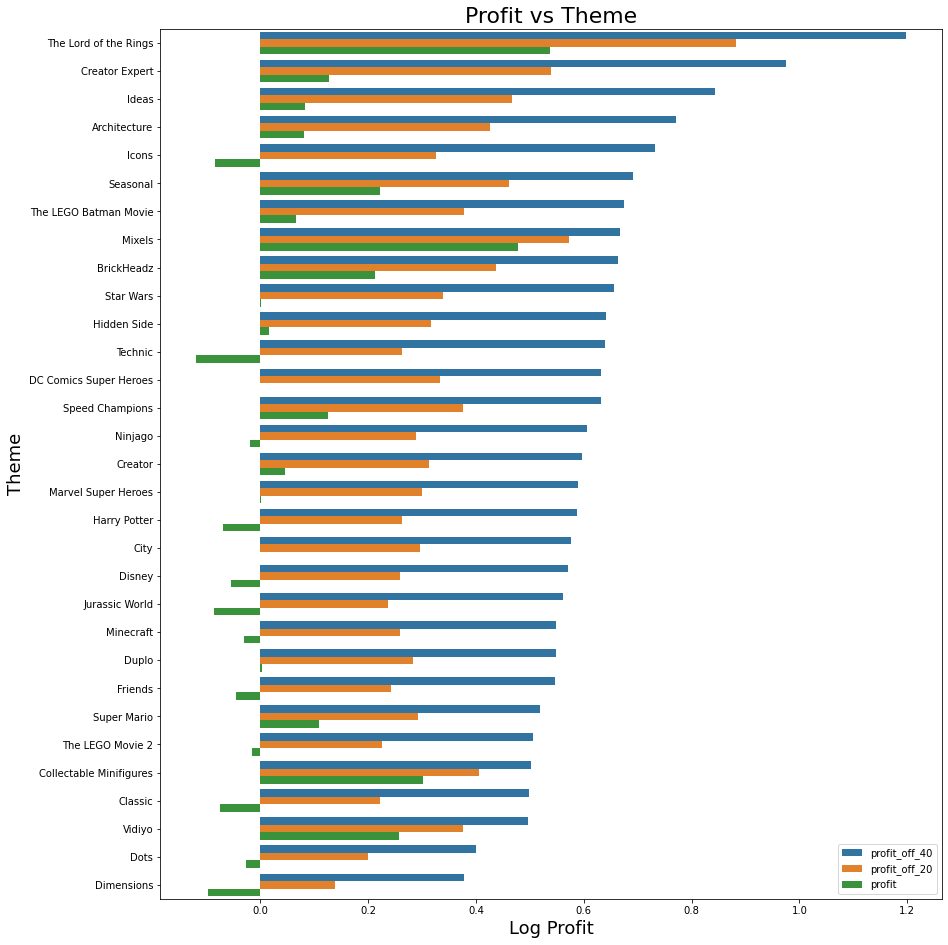

In [44]:
fig , ax = plt.subplots(figsize = (14,16))
ax = sns.barplot(data = dfl, y = 'Theme', x='values', hue='cats')
# ax.tick_params('x', labelrotation=90)
plt.legend()
plt.ylabel('Theme', size = 18)
plt.xlabel('Log Profit', size = 18)
plt.title('Profit vs Theme', size = 22)
plt.show()

Intersting findings here. 
* Some themes, such as 'Technic,' 'Dimensions,' or 'Icons,' yield negative profit when purchased at RRP, whilst 'Collectable Minifigures,' returns the highest profit. It is important to remember that all sales of the 'Collectable Minifigures' theme are small sets, and this is rarely on significant discount.
* All of the themes offer a positive median profit when purchased at 20% off RRP. Themes with the best profit margins are 'Creator Expert,' 'Ideas,' 'Architecture,' and 'Collectable Minifgures.' Dimensions, Dots, and Classis have the lowest profit return.
* Themes with the largest profit margins when purchased at 40% off RRP include 'Creator Expert,' 'Ideas,' and 'Architecture.' 'Collectable Minifigures' is now one among the top five least profitable themes. 'Super Mario,' 'Classic,' 'Dots,' and 'Dimensions' are the other four.

### 11. Last but not least, what is the relationship of Profit vs Year to Retire

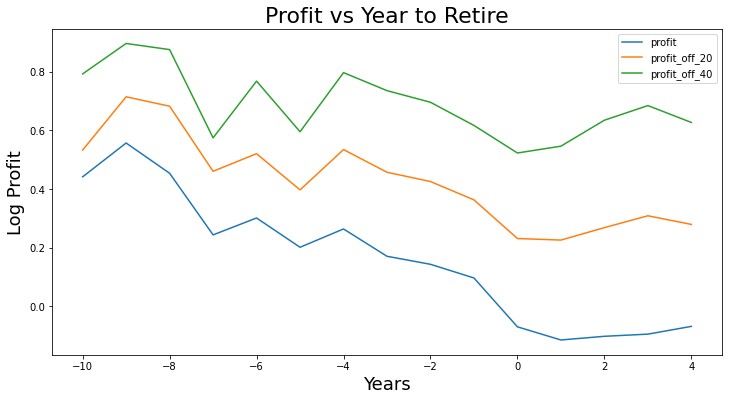

In [45]:
fig = df.groupby(['year_to_retire'])['profit'].median().plot(figsize = (12,6))
df.groupby(['year_to_retire'])['profit_off_20'].median().plot()
df.groupby(['year_to_retire'])['profit_off_40'].median().plot()
plt.legend()
plt.xlabel('Years', size = 18)
plt.ylabel('Log Profit', size = 18)
plt.title('Profit vs Year to Retire', size = 22)
plt.show()

Nothing out of the ordinary here; in general, the longer we keep the set, the more profit we can make. And if we can buy the set on sale, we can expect a similar profit in a shorter time frame. For example, for a set purchased at 40% off reail, a set retired 7 years ago had approximately the same profit as a set retired 1 year ago.

# Conclusion

The conclusion for this analysis is arranged as follows. First, of course, it is about what are the findings and observations of the analysis. And second, what I have learnt about the EDA process. Third is the limitation and future improvement.

1. Based on the analysis, the following findings can be given for the LEGO secondary market on Ebay in 2022, in this study: 
* Smaller sets with lower prices are easier to sell. The basic rule is that the smaller the set (i.e., the lower the price tag), the higher the chance the set can be sold. 
* Themes such as Collectable Minifigures, Star Wars, City, Marvel Super Heroes, Super Mario, and Harry Potter have higher demand than other themes, increasing the chance the set can be sold.
* Sets that have retired in the last two years or are about to retire have a higher chance of being sold.

Important points:
* It is critical not to buy at full retail price. Aim for a 40% or higher discount. Set in Themes such as Creator Expert, Ideas, Architecture, and Collectable Minifgures are fine with a 20% discount.
* Buying at retail price may result in a loss of money because the resell value is less than the retail price. Collectable Minifigures is the only theme worth considering at RRP since it still makes profit and generates a lot of demand on the secondary market owing to its low pricing.
* The same as the cheap price appealing, small set appears to always provide positive profit regardless of the RRP price. It could be beneficial if one of the strategies is to gain feedback and reputation on the selling platform.
* The medium size set yields the least profit. Purchasing a discounted and larger set to get the highest profit. 
* To avoid having to store the set for too long, it is advisable to collect/purchase it when it is due to retire within a year.
* On the other hand, holding a set for an extended period of time is unneeded and undesirable. The plan appears to be to sell in year 2 or 3 and reinvest to maintain the year on year consistency.

2. So what I have learnt about this project ?
* Understanding about the dataset
* Website scraping with BeautifulSoup
* DA with Pandas, Numpy, Matplotlib and Seaborn
* Python, Jupyter Notebook, Anaconda.
* Cleaning data process and the way to think about cleaning & structure data: filling missing data, filtering data, formating data, validate to generate deliverable data and the ability to generate useful insights via QA.


3. Limitation
* The data was scraped in a short period of time and does not represent a complete picture. I considered it as a small sample size, but it was sufficient for me to understand the present LEGO market. This provides me a direction for my LEGO secondary market idea as a side hobby.
* In general, the quality of Ebay data scraped is not perfect. Because it is possible to include multiple sets in one title/listing on Ebay, the method used to generate the set number is not ideal. There are other factors that might be used, such as minifigures or the average annual growth rate.
* For the reasons stated above, there are not many direct numerical or percentage calculations in the observations, such as the change in percentage over time or from theme to theme, and so on. The findings, however, make sense and are beneficial.


Future improvement:
* Improve the data set quality with better website scraping technique and filering process.
* Try different methodologies to analyse the data: such as ANOVA, t-test.
* Using machine learning to provide the reseld value price of a set.
